In [127]:
# dependencies :
import keras
import numpy as np 
import pandas as pd 
from keras.datasets import reuters
import matplotlib.pyplot as plt  
from matplotlib import style
style.use('ggplot')
import collections
import nltk
from nltk.corpus import stopwords

from collections import defaultdict
sns.set(rc={'figure.figsize':(11.7,8.27)})
from IPython.display import Math


# Table of contents : <br>
## 1. Exploratory analysis of the Dataset <br>
**1.1 Text preprocessing** <br>
**1.2 Analyzing the class distributions** <br>
**1.3 Further analysis**<br>
**1.4 Dimentionality reduction**<br>
> 1.4.1 Principal component analysis -> For top ten classes<br>
> 1.4.2 PCA with only top three classes<br>
> 1.4.3 Linear Discriminant Analysis (LDA) <br>
## 2.Train a Neural network Classifier to classify the news wires- Closed Set<br>
**2.1 Simple RNN Classifier: Model 1** <br>
> 2.1.1 Results <br>
> 2.1.2 Conculsions 
<br>

**2.2 Model 2 - Sequential**<br>
> 2.2.1 Results<br>
> 2.2.2 Conclusions<br>

**2.3 Model 3: Deeper Sequential model**<br>
> 2.3.1 Results<br>
> 2.3.2 Conclusions
<br>


**2.4 Precision, Recall and F1 score for all closed set classifiers**<br>
## 3.0 Open set classification<br>
**3.1 Neural network for Open set classification<br>
3.2 Results<br>
3.3 Conclusions**<br>
## References

# Introduction :
In this task I am going to work with 'The Reuters Newswire Dataset'. The following will  be my approach :
1. Exploratory analysis of the Dataset
2. Train a Neural network Classifier to classify the news wires
3. Report results based on given instructions in the task

## 1. Exploratory analysis of the Dataset 

* **Reuters** is a benchmark dataset for document classification. I will use keras to load the dataset. The dataset is already well pre processed in keras. (stemming, lemmatization is done)
* Number of datapoints - 11,228 newswires from Reuters, Total number of classes (topics) - 46 

Lets verify this by looking into the dataset.




#### Loading Data Set :

In [369]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=None,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

#################################################################################################
# * The dataset is downloaded from reuters.npz and the path ->"reuters_word_index.json"
#   contains JSON file (key-value) to map the words with the index.
# * Also important to mention is that, the 'Index' is the 'rank' of the word. i.e. if 'the'
#   occurs the maximum number of times(frequency), its index will be 1.
#################################################################################################

In [ ]:
'''Needed to do this because of conflicts from 'index_from=3' default parameter in keras load dataset function'''
# for i in x_train:
#     try:
#         i.remove(30980)
#     except:
#         print('not in list')
#     try:
#         i.remove(30981)
#     except:
#         print('not in list')
        

In [ ]:
# for i in x_test:
#     try:
#         i.remove(30980)
#     except:
#         print('not in list')
#     try:
#         i.remove(30981)
#     except:
#         print('not in list')

In [6]:
assert(len(x_train)==len(y_train))    #to make sure dataset is loaded correctly
assert(len(x_test)==len(y_test))
print('Number of Training Samples: {}'.format(len(y_train)))
print('Number of Test Samples: {}'.format(len(y_test)))
print('Number of classes: ', np.max(y_train)+1)        # plus one because indexing of categories starts at 0


Number of Training Samples: 8982
Number of Test Samples: 2246
Number of classes:  46


### 1.1 Text preprocessing :
Steps :
* Save the newswires dataset in text format
* Remove some stopwords further
* Apply some text pre processing techniques - Stemming, Lemmatzing, tf-idf, word embeddings
* Save different modules of preprocessed data (e.g. module1 - stemmed + lemmatized, module2 - tf-idf etc) <br>
* Later experiment with all modules of the datasets and check metrics[Confusion Matrix, cross-entropy loss].

In [7]:
word_to_index = reuters.get_word_index(path="reuters_word_index.json") #Getting the word with their index using the inbuilt function

In [8]:
word_to_index = reuters.get_word_index(path="reuters_word_index.json") #Getting the word with their index using the inbuilt function
# dictionary {'WORD' : INDEX}  
'''This functions returns 'n' newswires as text'''
def get_newswire(n,X):
    index_to_word = {}
    for key, value in word_to_index.items():     # to loop over the dict object
        index_to_word[value] = key          # appending the dictionary {INDEX : 'WORD'}  (inverse dictionary!)
    wires = []
    #myDict = defaultdict(dict)
    for i in range(n):
        wire =(' '.join(index_to_word[x] for x in X[i]))
        wires.append(wire)
    return wires
wires_train = get_newswire(len(x_train),x_train)
wires_test = get_newswire(len(x_test),x_test)
print('The first news wire from training set is:')
wires_train[0]

The first news wire from training set is:


'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

**By printing this we can quicky see that some lemmatization and stemming has already been done**


In [9]:
'''Removing stopwords'''
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 
def remove_stop_words(X):
    filtered_wires =[]
    for i in range(len(X)):
        word_tokens = word_tokenize(X[i] )
        filtered_sentence = [w for w in word_tokens if not w in stop_words] 
        filtered_wires.append(filtered_sentence)
    return filtered_wires
wires_train= remove_stop_words(wires_train)
wires_test=remove_stop_words(wires_test)



Lets *tokenize* the news wire and prepare the final data for NN training. I will use the 'binary' mode<br>
because of the large size of vocabulary. 

In [372]:
from keras.preprocessing.text import Tokenizer
max_words = 15000
num_classes = 46
tokenizer = Tokenizer(num_words=max_words)
x_train_final = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test_final = tokenizer.sequences_to_matrix(x_test, mode='binary')

y_train_final = keras.utils.to_categorical(y_train, num_classes)
y_test_final = keras.utils.to_categorical(y_test, num_classes)

print('Sample final x value :')
print(x_train_final[0])

Sample final x value :
[0. 1. 0. ... 0. 0. 0.]


We can see above that the binary encoded x_train values denote 0 if the word doesnt exist and 1 if it exists out of # max_words

In [11]:

print('Sample from Y values -> Categorical one hot encoding')
print(y_train_final[0])

Sample from Y values -> Categorical one hot encoding
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Thus, y_train_final value is one hot encoded and it means the first sample belongs to class ID 3, as the value is 1 at ID 3.

In [12]:
print('The shape of X_train is:')
print(x_train_final.shape)
print('The shape of y_train is')
print(y_train_final.shape)

The shape of X_train is:
(8982, 15000)
The shape of y_train is
(8982, 46)


### 1.2 Analyzing the class distributions :

At this point I would like to explore the distribution of classes in this dataset. As we know there are 46 classes<br>we can see how the histogram looks like to get an Idea about class ditributions.

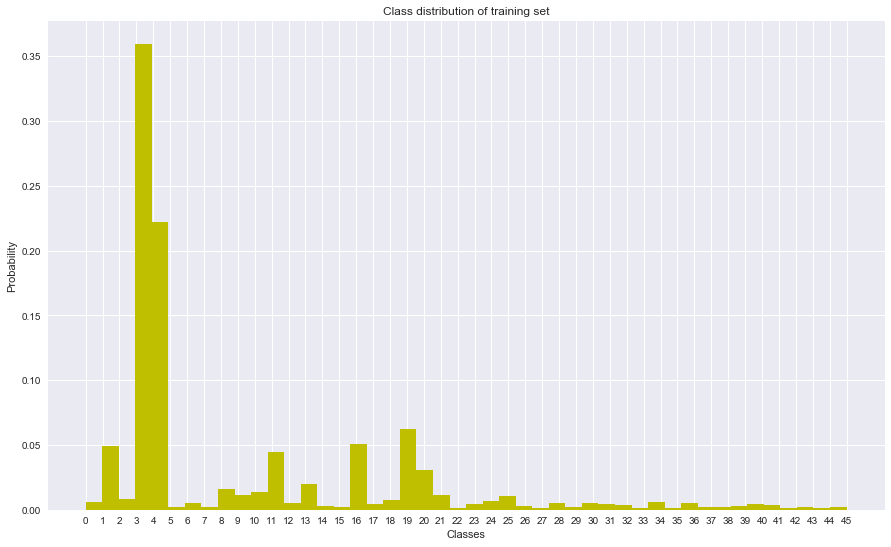

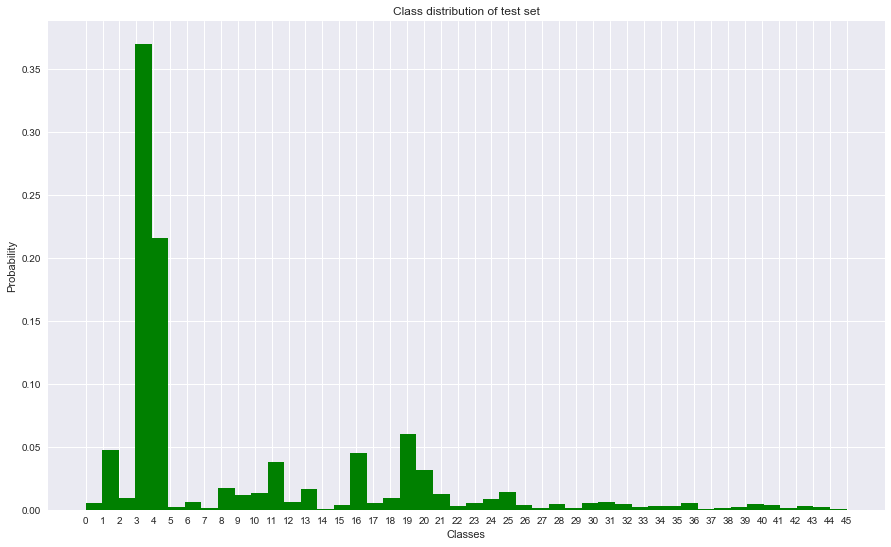

,Top classes,Frequency of samples
0,3,3159
1,4,1949
2,19,549
3,16,444
4,1,432
5,11,390
6,20,269
7,13,172
8,8,139
9,10,124


In [373]:
plt.figure(figsize=(15,9))
plt.hist(y_train, bins=46, density=True, facecolor='y')
plt.xticks(np.arange(0,46))
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class distribution of training set')
plt.show()

plt.figure(figsize=(15,9))
plt.hist(y_test, bins=46, density=True, facecolor='g')
plt.xticks(np.arange(0,46))
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class distribution of test set')
plt.show()

def most_common_classes(n,Y_TRAIN,Y_TEST):
    '''This function return the top Nm ost common classes'''
    c= collections.Counter(Y_TRAIN)
    d=collections.Counter(Y_TEST)
    classes =[]
    frequency =[]
    
    for i in range(len(c.most_common(n))):
        classes.append(c.most_common(n)[i][0])
        frequency.append(c.most_common(n)[i][1])
    df =pd.DataFrame(data={'Top classes':classes,'Frequency of samples':frequency})
    
    
    return df
  

most_common_classes(10,y_train,y_test)

* As we can see from the Histogram, there is a peak at class probabilty of index '3'. Thus, this is the most probable class.
* The distribution seems quite imbalanced with respect to the class distributions as the frequencies for classes (3, 4, 19, 16, 1) dominates with almost ~6000 samples in total. Thats almost 75 percent of the data points. See the table below.
* The result of having too many examples of one sample might be underfitting to classes which occur less and overfitting to these 4 most common classes. In such a case a good idea will be to gather more data, or generate data using some **data augmentation** to generate more data which belongs to other classes as well.
* For an unbalanced dataset, I will choose to **not** use Accuracy as the success metric. Confusion matrix and/or F1 score might give a better idea about the goodness of fit for a model.

### 1.3 Further analysis :
Lets get an Idea what is the size of vocabulary in this dataset.

In [14]:
print('The number of unique words in this corpora : ',len(word_to_index))
index_to_word = {}
for key, value in word_to_index.items():     # to loop over the dict object
    index_to_word[value] = key


def most_common_words(n):
    '''As we know that the index is the rank of the word based on Frequency, lets print out
a few most common occurring words'''
    top_words=[]
    for i in range(1,n):
        top_words.append(index_to_word[i])
    return  print('The most common {} words are:'.format(n),top_words)

most_common_words(50)

The number of unique words in this corpora :  30979
The most common 50 words are: ['the', 'of', 'to', 'in', 'said', 'and', 'a', 'mln', '3', 'for', 'vs', 'dlrs', 'it', 'reuter', '000', '1', 'pct', 'on', 'from', 'is', 'that', 'its', 'cts', 'by', 'at', 'year', 'be', 'with', '2', 'will', 'was', 'billion', 'he', 'u', 's', 'net', 'has', 'would', 'an', 'as', '5', 'not', 'loss', '4', '1986', 'company', 'which', 'but', 'this']


Above, I can also further shorten the size of the vocab  by removing some more words like (the, of, to, in, a etc)from the newswires. <br>
But because of time constraints I will skip this step.


**So far we know that the dataset is unbalanced as almost 45 percent of the words are in one class->'3'**
* I would like to do some more exploratory analysis to vizualize the class correlations. To do this, I will use dimensionality reduction method viz. principle component analyisis or LDA.
* I would do so because the data points are high dimensional(~vocabulary size=30979). But I will limit the dimension of 
  the datapoint by fixing the vocab size to 15000, i.e. 15000 most common words. Although 15000 is still a big number let us see   what we get.

**Below I define a function which gives me dataset which contains only the top 'n' classes. As mentioned in the task,
I will use top ten classes**

In [331]:

def get_data(X,Y,Y_TEST,num_classes):
    
###########################################################################################
#   This function returns form the overall data only those which belong to top N classes
#   Important: for X, input->Binary coded fixed length array
#   for Y, input-> the one **NOT** one-hot encoded'''
###########################################################################################
    x_train=[]
    y_train=[]
    top_n_classes=most_common_classes(num_classes,Y,Y_TEST)['Top classes']
    XY= []
    for i in range(len(X)):
        xy = np.hstack((X[i],Y[i]))
        XY.append(xy)
    for i in range(len(XY)):
        if np.isin(XY[i][-1],top_n_classes)==True:
            x_train.append(XY[i][:15000])
            y_train.append(XY[i][-1])
    return (x_train,y_train)

x_train_i,y_train_i=get_data(x_train_final,y_train,y_test,num_classes=10)
x_test_i,y_test_i=get_data(x_test_final,y_test,y_test,num_classes=10)

In [308]:
print('Top ten classes remianing in the dataset:')
np.unique(y_train_i)

Top ten classes remianing in the dataset:


array([ 1.,  3.,  4.,  8., 10., 11., 13., 16., 19., 20.])

In [311]:
print('From Top TEN classes->')
print('Samples left in train set:',len(x_train_i),'out of',len(x_train))
print('Samples left in test set:',len(x_test_i),'out of',len(y_test))

From Top TEN classes->
Samples left in train set: 7627 out of 8982
Samples left in test set: 1883 out of 2246


Its easy to notice here that out of 8982 samples, 7627 belong to the top ten classes. Also visible from the class distribtution.

### 1.4 Dimentionality reduction : 
#### 1.4.1 Principal component analysis -> For top ten classes:
I will use dimensionality reduction method viz. principle component analyisis or LDA.
I chose this method because the data points are high dimensional(~vocabulary size=30979). But I will limit the dimension of 
the datapoint by fixing the vocab size to 15000, i.e. 15000 most common words.

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_i)


In [19]:
XY= []
for i in range(len(X_pca)):
    xy = np.hstack((X_pca[i],y_train_i[i]))
    XY.append(xy)

In [20]:
finalDf=pd.DataFrame(XY,columns=['principal component 1','principal component 2','target'])
finalDf.head()

,principal component 1,principal component 2,target
0,-0.300755,0.436084,3.0
1,-0.419466,-1.375142,4.0
2,-1.936068,2.394999,3.0
3,1.812214,-0.221096,4.0
4,0.610501,-1.411384,4.0


#### Viazualizing PCA :

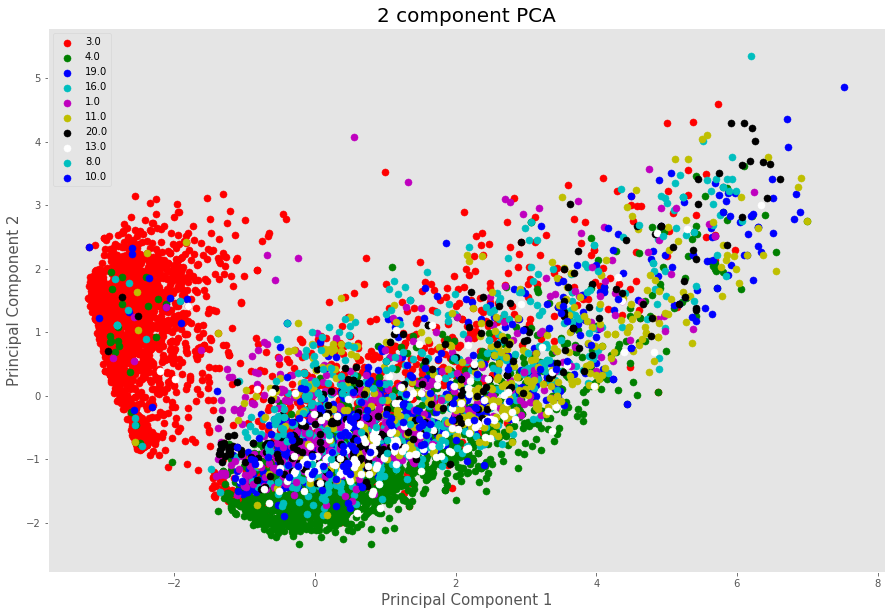

In [21]:

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = np.array(most_common_classes(10,y_train_i,y_test_i)['Top classes in TRAIN'])
colors = ['r', 'g', 'b','c','m','y','k','w','c','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [22]:
pca.explained_variance_ratio_

array([0.07294754, 0.02332837])

* The explained variance is quite low for both the components. 
* This is because of very high number of attributes(15000) and the pca has 2 components 
  only. 
* To fit LDA and vizualize attributes that account for the most variance between classes would be my next approach.<br>
  However, i will skip this part for now and move on to neural network training, for the scope of this task.
* Any way using LDA for a supervised problem is better approach.

In [30]:
x_train_3,y_train_3 =get_data(x_train_final,y_train,y_test,num_classes=3)

In [32]:
x_test_3,y_test_3 =get_data(x_test_final,y_test,y_test,num_classes=3)

#### 1.4.2 PCA with only top three classes :

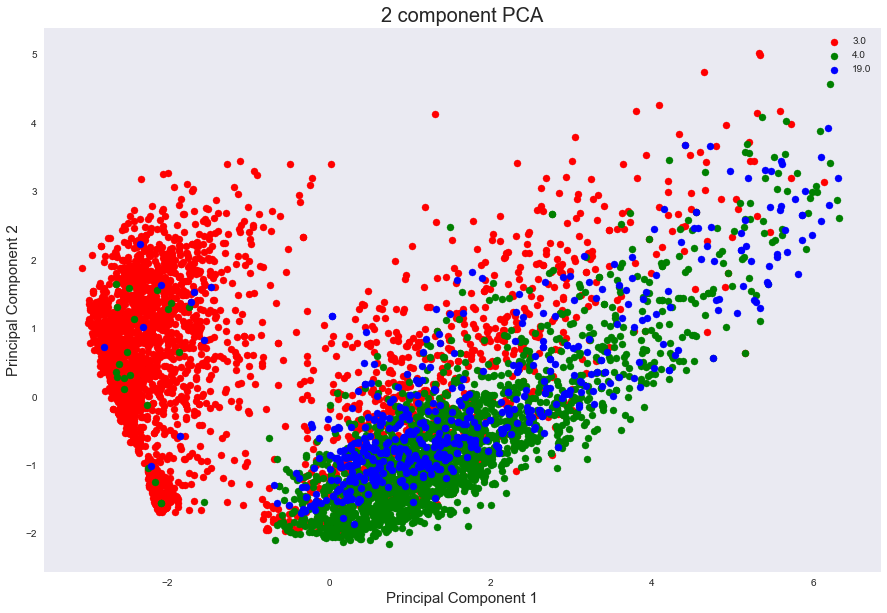

Explained variance ratio is : [0.08232908 0.02857908]


In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_3)
XY= []
for i in range(len(X_pca)):
    xy = np.hstack((X_pca[i],y_train_3[i]))
    XY.append(xy)
    
finalDf=pd.DataFrame(XY,columns=['principal component 1','principal component 2','target'])
finalDf.head()

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = np.array(most_common_classes(3,y_train_3,y_test_3)['Top classes in TRAIN'])
colors = ['r', 'g', 'b','c','m','y','k','w','c','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()
print('Explained variance ratio is :',pca.explained_variance_ratio_)

* From this it is interesting to notice that some attributes (vocabulary) exists only in documents belonging to 
    class '3' (in red). 
* Vocabularies within class '4' (in green) and '19' (in blue) has some or many words in common.

### 1.4.3 Linear Discriminant Analysis (LDA) 
* Let us also apply Linear Discriminant Analysis (LDA) to the dataset **with only top three classes**  and  vizualize the plot

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [35]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(x_train_3,y_train_3 ).transform(x_train_3)

C:\Users\Ankit\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


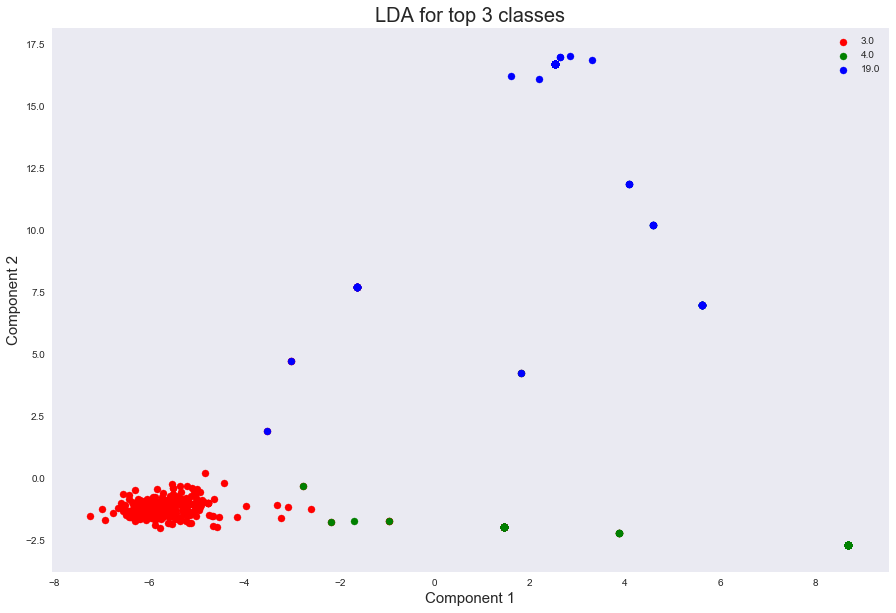

In [334]:
XY= []
for i in range(len(X_r2)):
    xy = np.hstack((X_r2[i],y_train_3[i]))
    XY.append(xy)
    
finalDf=pd.DataFrame(XY,columns=['principal component 1','principal component 2','target'])
finalDf.head()

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('LDA for top 3 classes', fontsize = 20)
targets = np.array(most_common_classes(3,y_train_3,y_test_3)['Top classes'])
colors = ['r', 'g', 'b','c','m','y','k','w','c','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

**Deductions** :
* From this I can say that attributes in class '4' and '19' have high variance in the vocabulary


# 2.Train a Neural network Classifier to classify the news wires

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, Flatten
from keras.layers import Embedding, SimpleRNN
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

## Closed set classification :
First three parts of this section are dedicated to building RNN and DNN for classifying TOP TEN classes.

In [336]:
'''Funciton plots accuracy and loss graph'''
def plot_metrics(model_history,modelid):
    
    pd.Series(model_history.history['loss']).plot(logy=True)
    plt.xlabel("Epoch")
    plt.title('Loss of train set->model {}'.format(modelid))
    plt.ylabel("Loss")
    plt.show()
   
    pd.Series(model_history.history['acc']).plot(logy=True)
    plt.xlabel("Epoch")
    plt.title('Accuracy of train set->model {}'.format(modelid))
    plt.ylabel("Accuracy")
    plt.show()
    
    
'''This function returns the predicted classes form the indices returned by model.predict'''

def pred_to_class1(model,x_test,y_test,num_classes):
    top_n_classes=most_common_classes(num_classes,y_train_i,y_test_i)['Top classes']  
    top_n_classes=np.sort(np.asarray(top_n_classes))
    y_proba = model.predict(x_test)
    y_classes = y_proba.argmax(axis=-1)
    pred= []
    for i in range(len(y_classes)):
        pred.append(top_n_classes[y_classes[i]])
    return pred

**Final data and tensor shapes ->**

In [318]:
''' 
The final data containing only 10 classes have the following variable names ->

x_train_i  , y_train_i
x_test_i_encoded , y_test_i_encoded


'''
x_train_i =np.asarray(x_train_i)
y_train_i =np.asarray(y_train_i)
x_test_i =np.asarray(x_test_i)
y_test_i =np.asarray(y_test_i)
print('shape of x_train :',x_train_i.shape )
print('shape of y_train :',y_train_i_encoded.shape )
print('shape of x_test :',x_test_i.shape )
print('shape of y_test :',y_test_i_encoded.shape )
print('Unique top ten classes in y->,',np.unique(y_train_i))

shape of x_train : (7627, 15000)
shape of y_train : (7627, 10)
shape of x_test : (1883, 15000)
shape of y_test : (1883, 10)
Unique top ten classes in y->, [ 1.  3.  4.  8. 10. 11. 13. 16. 19. 20.]


In [24]:
'''
Here I tokenize the Y values to use it finally for training
'''
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train_i)
print('Unique classes are',lb.classes_)

y_train_i_encoded =lb.transform(y_train_i)


Unique classes are [ 1.  3.  4.  8. 10. 11. 13. 16. 19. 20.]


In [25]:
lb = preprocessing.LabelBinarizer()       
lb.fit(y_test_i)
print('Unique classes in test set are',lb.classes_)

y_test_i_encoded =lb.transform(y_test_i)

Unique classes in test set are [ 1.  3.  4.  8. 11. 13. 16. 19. 20. 25.]


## 2.1 Simple RNN Classifier: Model 1 

**Model:**

In [68]:
model = Sequential()
model.add(Embedding(15000, 64))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train_i, y_train_i_encoded,
                    epochs=3,
                    batch_size=128,
                    validation_split=0.3)

Train on 5338 samples, validate on 2289 samples
Epoch 1/3
5338/5338 [==============================] - 6022s 1s/step - loss: 1.8224 - acc: 0.3767 - val_loss: 1.7283 - val_acc: 0.4120
Epoch 2/3
5338/5338 [==============================] - 6228s 1s/step - loss: 1.7451 - acc: 0.4153 - val_loss: 1.7348 - val_acc: 0.4120
Epoch 3/3
5338/5338 [==============================] - 6208s 1s/step - loss: 1.7368 - acc: 0.4151 - val_loss: 1.7276 - val_acc: 0.4120


**Saving and loading the model weights :**

In [69]:
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model1.h5")


In [97]:
# load json and create model
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model1.h5")
print("Loaded model from disk")

Loaded model from disk


**Evaluate loaded model on data**


In [98]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


score = loaded_model.evaluate(x_test_i, y_test_i_encoded, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

### 2.1.1 Results

#### Test set results for model 1:

In [100]:
print('The accuracy on the test set is:')
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

The accuracy on the test set is:
acc: 43.18%


In [341]:
pred= pred_to_class1(loaded_model,x_test=x_test_i,y_test=y_test_i,num_classes=10)

Confusion matrix for RNN model (Closed set): Test set


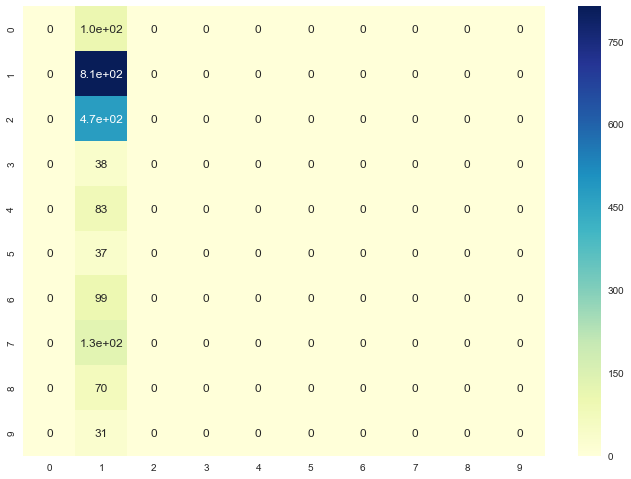

In [217]:
matrix = confusion_matrix(y_test_i,pred)
print('Confusion matrix for RNN model (Closed set): Test set')
ax = sns.heatmap(matrix,cmap="YlGnBu",annot=True)

#### Train set results for model 1:

In [342]:
pred_1_train =pred_to_class1(loaded_model,x_test=x_train_i,y_test=y_train_i,num_classes=10)

Confusion matrix for RNN model (Closed set): Train set


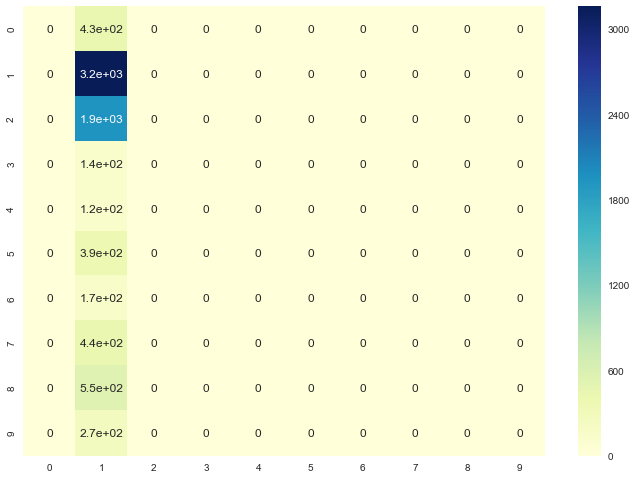

In [219]:
matrix = confusion_matrix(y_train_i,pre_train)
print('Confusion matrix for RNN model (Closed set): Train set')

ax = sns.heatmap(matrix,cmap="YlGnBu",annot=True)

### 2.1.2 Conculsions  :
* RNN has been trained for only three epochs and has not learnt much. This is evident from the fact that most newwires in both 
  train or test set has been mis classified(see HeatMap).
* Because of weak resources I was not able to train and check other configurations of RNN's. The model above took 6 hours to   train on my system.
* Also, reducing the vocab size further might actually help gain better results. This is because of so many words which do not carry *context* lies in the dataset as mentioned before in section 1.3 (Further analysis)

## 2.2 Model 2 - Sequential

To get some better results to work with, I will use Sequential model for this task further

**Model:**

In [314]:
model2 = Sequential()
model2.add(Dense(512, input_shape=(max_words,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10))
model2.add(Activation('softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary)

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x000001860D1F3B00>>


In [315]:
batch_size = 32
epochs = 3

history = model2.fit(x_train_i, y_train_i_encoded, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score = model2.evaluate(x_test_i, y_test_i_encoded, batch_size=batch_size, verbose=1)

Train on 6864 samples, validate on 763 samples
Epoch 1/3
6864/6864 [==============================] - 31s 5ms/step - loss: 0.7029 - acc: 0.8214 - val_loss: 0.5138 - val_acc: 0.8820
Epoch 2/3
6864/6864 [==============================] - 30s 4ms/step - loss: 0.2835 - acc: 0.9328 - val_loss: 0.5924 - val_acc: 0.8702
Epoch 3/3
1883/1883 [==============================] - 1s 431us/step


### 2.2.1 Results

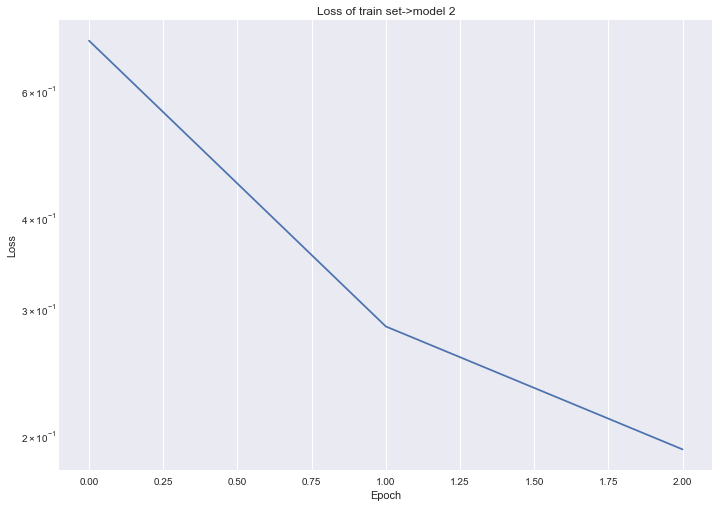

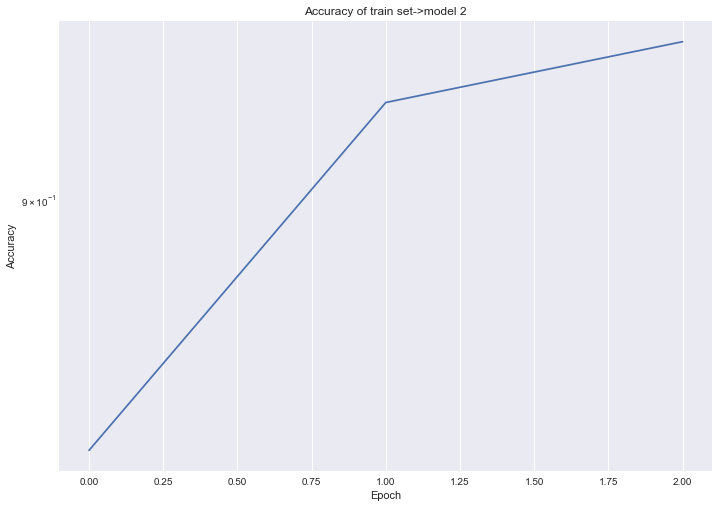

In [316]:
plot_metrics(history,modelid=2)

In [52]:
# Save weights
# model_json = model2.to_json()
# with open("model2.json", "w") as json_file:
#     json_file.write(model_json)
# model2.save_weights("model2.h5")


# load json and create model
# json_file = open('model2.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model2.h5")
# print("Loaded model from disk")

**Test set results for MODEL 2 :**

In [51]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.9988207099162956
Test accuracy: 0.703133298308686


In [337]:
pred_2=pred_to_class1(model2,x_test_i,y_test_i,num_classes=10)

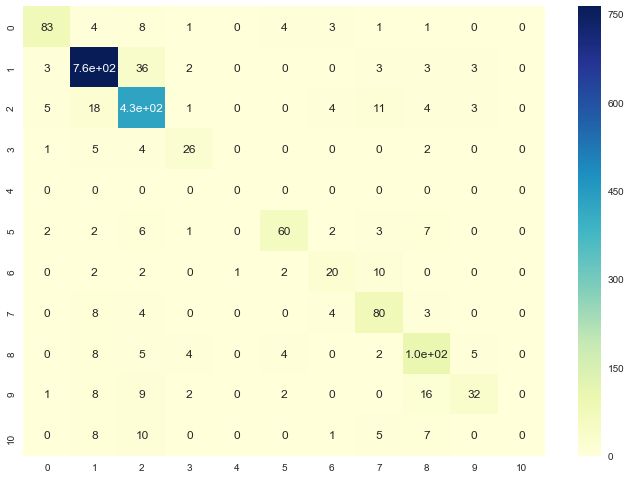

In [212]:
matrix = confusion_matrix(y_test_i,pred_2)
ax = sns.heatmap(matrix,cmap="YlGnBu",annot=True)

**Train set results for MODEL2 :**

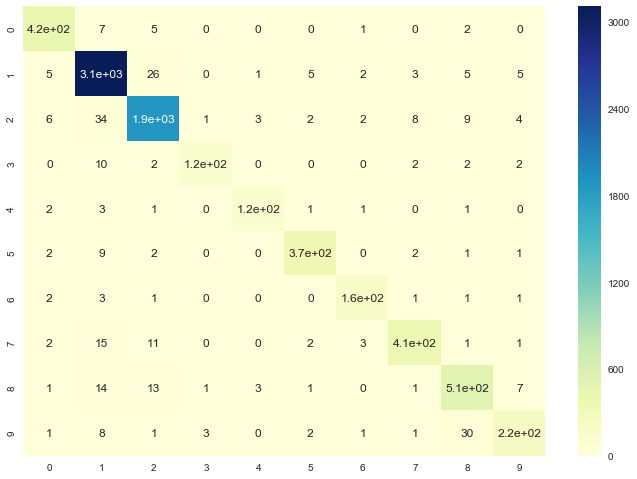

In [338]:
pred_2_train=pred_to_class1(model2,x_train_i,y_train_i,num_classes=10)
matrix = confusion_matrix(y_train_i,pred_2_train)
ax = sns.heatmap(matrix,cmap="YlGnBu",annot=True)

### 2.2.2 Conclusions :
* The number of correct classifications done by this model is high. 
* From the confusion matrix its evident that almost 3000 out of 3195 samples in Class ID '1' which belongs to the top class ->3 have been correctly labeled by this classifier.
* Similarly for other classes, number of correct classifications(diagnol of the confusion matrix) we can see that many samples have been rightly identified.
* However, there are still many samples which are wrongly labeled. There is always a chance of improvement.<br>
<br>In the next step, I will make the model more deep by adding more dense layers with dropout and Relu activation and analyse its performance.

## 2.3 Model 3: Deeper Sequential model

**Model:**

In [120]:
model3 = Sequential()
model3.add(Dense(512, input_shape=(max_words,)))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(256, input_shape=(max_words,)))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(128, input_shape=(max_words,)))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(64, input_shape=(max_words,)))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(10))
model3.add(Activation('softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

batch_size = 32
epochs = 20

history = model3.fit(x_train_i, y_train_i_encoded, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score = model3.evaluate(x_test_i, y_test_i_encoded, batch_size=batch_size, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               7680512   
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_16 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
__________

In [121]:
# Save weights
# model_json = model3.to_json()
# with open("model3.json", "w") as json_file:
#     json_file.write(model_json)
# model3.save_weights("model3.h5")


# load json and create model
# json_file = open('model3.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model3.h5")
# print("Loaded model from disk")

### 2.3.1 Results

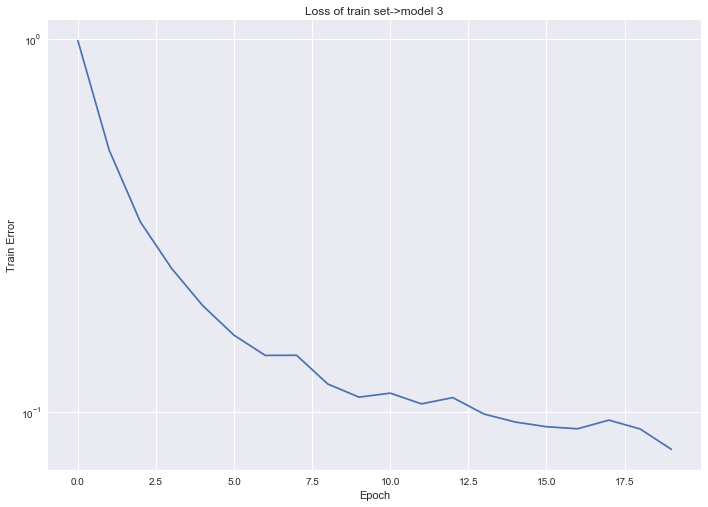

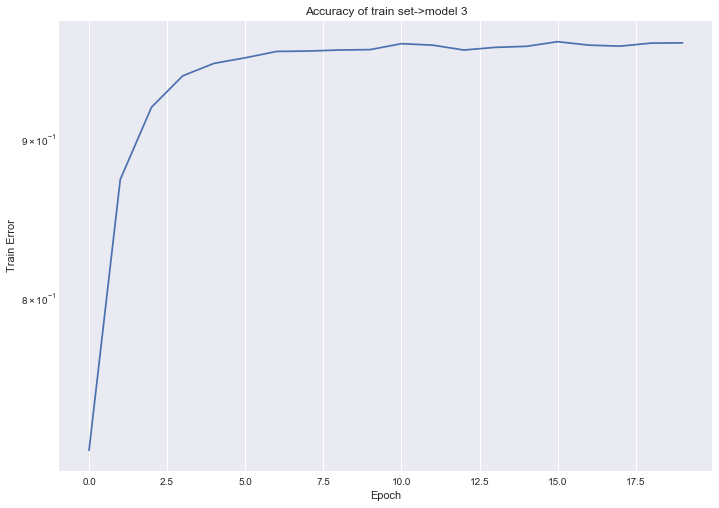

In [122]:
plot_metrics(history,modelid=3)

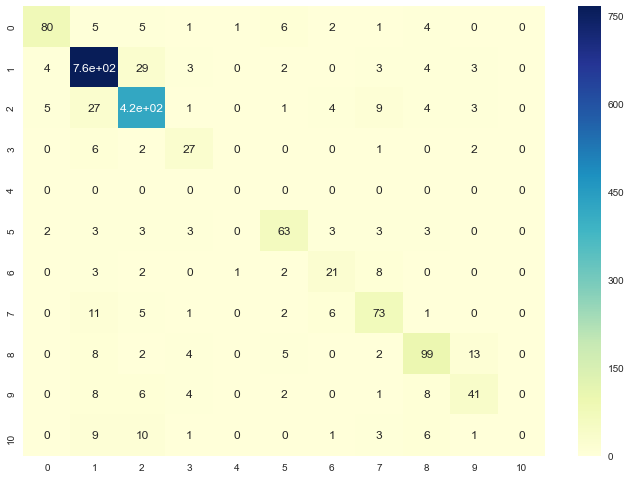

In [339]:
pred_3=pred_to_class1(model3,x_test_i,y_test_i,num_classes=10)
matrix = confusion_matrix(y_test_i,pred_3)
ax = sns.heatmap(matrix,cmap="YlGnBu",annot=True)

Figure above shows the confusion matrix for the **test** set.

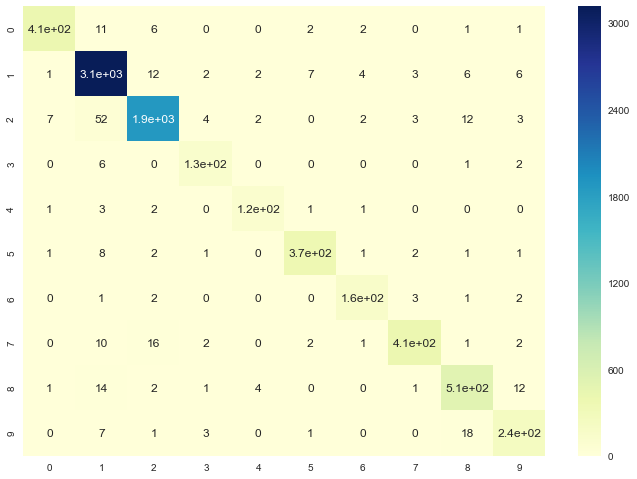

In [340]:
pred_3_train=pred_to_class1(model3,x_train_i,y_train_i,num_classes=10)
matrix = confusion_matrix(y_train_i,pred_3_train)
ax = sns.heatmap(matrix,cmap="YlGnBu",annot=True)



Figure above shows the confusion matrix for the **Train** set.

### 2.3.2 Conclusions:
* From the confusion matrix we get a good idea of the Recall and Precision. 
* The model has predicted labels with considerable accuracy in both train and test sets.

<br> To quantify our assumptions of goodness of fit, I will tabulate the Precision, recall and F1 score in a table

## 2.4 Precision, Recall and F1 score for all closed set classifiers :


In [351]:
from sklearn.metrics import precision_recall_fscore_support
model3_f1_test=precision_recall_fscore_support(y_test_i, pred_3, average='macro') 
model3_f1_train=precision_recall_fscore_support(y_train_i, pred_3_train, average='macro')
model2_f1_test=precision_recall_fscore_support(y_test_i, pred_2, average='macro') 
model2_f1_train=precision_recall_fscore_support(y_train_i, pred_2_train, average='macro')
model1_f1_test=precision_recall_fscore_support(y_test_i, pred, average='macro') 
model1_f1_train=precision_recall_fscore_support(y_train_i, pred_1_train, average='macro')
df_f1_train =pd.DataFrame(data={'Precision':[model1_f1_train[0],model2_f1_train[0],model3_f1_train[0]],'Recall':[model1_f1_train[1],model2_f1_train[1],model3_f1_train[1]],'F1-score':[model1_f1_train[2],model2_f1_train[2],model3_f1_train[2]]},index=['RNN','DNN','Deeper DNN'])
df_f1_test =pd.DataFrame(data={'Precision':[model1_f1_test[0],model2_f1_test[0],model3_f1_test[0]],'Recall':[model1_f1_test[1],model2_f1_test[1],model3_f1_test[1]],'F1-score':[model1_f1_test[1],model2_f1_test[1],model3_f1_test[1]]},index=['RNN','DNN','Deeper DNN'])

C:\Users\Ankit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ankit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ankit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ankit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Ankit\Anaconda3\lib\sit

**Train set->**

In [352]:
df_f1_train

,Precision,Recall,F1-score
RNN,0.041419,0.100000,0.058576
DNN,0.947807,0.928719,0.937753
Deeper DNN,0.945372,0.941250,0.943181


**Test set->**

In [353]:
df_f1_test

,Precision,Recall,F1-score
RNN,0.043176,0.100000,0.100000
DNN,0.625058,0.634493,0.634493
Deeper DNN,0.608998,0.608502,0.608502


Conclusions :
* Model 1- RNN : This model is not well trained. The recall and precision is very low. 
* Model 2- DNN : The train set F1 score is really high but for the test is quite low. This is an alarm for **overfitting** to the train set. First measures-> increase dropout and consider early stopping in cases of longer training.
* Model 3 - Deeper DNN : This model has a better *recall* than the model 2. However, for the training set its the opposite. Overall, the average (harmonic mean) of precision and recall is better for model 2.
* Thus making the network more deep does not nessacarily enhance the performance.

# 3.0 Open set classification :

**Approach**

For extending this classifier for open set problem, my first strategy will be a very simple indepedent approach.
My approach -> 
1. Convert the output layer to 11 neurons. 
     * Ten for the ten classes plus one for *rejection*
     * Modify Y values (labels) to 11 classes i.e ID='47' for rejection. (currently there are 0-9 for class labels of ten classes)
2. Use this modified dataset and train the classifier. Thus the network *backpropagates* over classification error with 11 classes, one of which belonging to the rejection class.

3. Evaluate :
    * To evaluate, I will calculate detection/rejection ratio as:

\begin{equation*}
Detection\; Accuracy = \frac{Number\; of\; samples\; CORRECTLY\; REJECTED\;}{\; Total\; number\; of\; samples\; belonging\; to\; REJECTION\; class\;} 
\end{equation*}

In [186]:
'''Preparing the dataset'''
top_n_classes =np.asarray(top_n_classes)
top_n_classes

array([ 3.,  4., 19., 16.,  1., 11., 20., 13.,  8., 10.])

In [170]:
# 'Y_TRAIN and TEST' now contains top ten classes and all other classes as 11th class with label ID 47, thus total 11 classes
for i in range(len(y_train)):
    if (y_train[i] not in top_n_classes):
        y_train[i] = 47
    
for i in range(len(y_test)):
    if (y_test[i] not in top_n_classes):
        y_test[i] = 47


array([ 3.,  4., 19., 16.,  1., 11., 20., 13.,  8., 10.])

In [171]:
print('class labels in y_train are:', np.unique(y_train))

class labels in y_train are: [ 1  3  4  8 10 11 13 16 19 20 47]


In [176]:
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
print('Unique classes train set are',lb.classes_)

y_train_11_encoded =lb.transform(y_train)


lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
print('Unique classes in test set are',lb.classes_)

y_test_11_encoded =lb.transform(y_test)


Unique classes train set are [ 1  3  4  8 10 11 13 16 19 20 47]
Unique classes in test set are [ 1  3  4  8 10 11 13 16 19 20 47]


In [175]:
print('One hot encoded Y is of the shape: ',y_train_11_encoded.shape)

One hot encoded Y is of the shape:  (8982, 11)


## 3.1 Neural network for Open set classification :
As RNN is really tough to train on the system I am using, I will keep the model sequential and with Dense layers.
The design and training of the network is however based on the concept of open set problem, as I am training the classifier<br>
for 10 + 1(rejection) class

**Model:**

In [191]:
num_classes =11
model4 = Sequential()
model4.add(Dense(512, input_shape=(max_words,)))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary)

batch_size = 32
epochs = 20

history = model4.fit(x_train_final, y_train_11_encoded, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score = model4.evaluate(x_test_final, y_test_11_encoded, batch_size=batch_size, verbose=1)

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x000001860C201748>>
Train on 8083 samples, validate on 899 samples
Epoch 1/20
8083/8083 [==============================] - 35s 4ms/step - loss: 0.8285 - acc: 0.7777 - val_loss: 0.6466 - val_acc: 0.8265
Epoch 2/20
8083/8083 [==============================] - 34s 4ms/step - loss: 0.3500 - acc: 0.9151 - val_loss: 0.6913 - val_acc: 0.8265
Epoch 3/20
8083/8083 [==============================] - 34s 4ms/step - loss: 0.2246 - acc: 0.9445 - val_loss: 0.7405 - val_acc: 0.8209
Epoch 4/20
8083/8083 [==============================] - 35s 4ms/step - loss: 0.1843 - acc: 0.9557 - val_loss: 0.8183 - val_acc: 0.8076
Epoch 5/20
8083/8083 [==============================] - 35s 4ms/step - loss: 0.1667 - acc: 0.9569 - val_loss: 0.8512 - val_acc: 0.7964
Epoch 6/20
8083/8083 [==============================] - 36s 4ms/step - loss: 0.1688 - acc: 0.9578 - val_loss: 0.8658 - val_acc: 0.8087
Epoch 7/20
8083/8083 [=====================

In [ ]:
top_n_classes=most_common_classes(num_classes,y_train,y_test)['Top classes in TRAIN']  
top_n_classes=np.sort(np.asarray(top_n_classes))
top_n_classes

In [224]:
y_proba = model4.predict(x_test_final)

In [226]:
y_classes = y_proba.argmax(axis=-1)

In [229]:
np.unique(y_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [230]:
pred= []
for i in range(len(y_classes)):
    pred.append(top_n_classes[y_classes[i]])

## 3.2 Results :

**Test set**

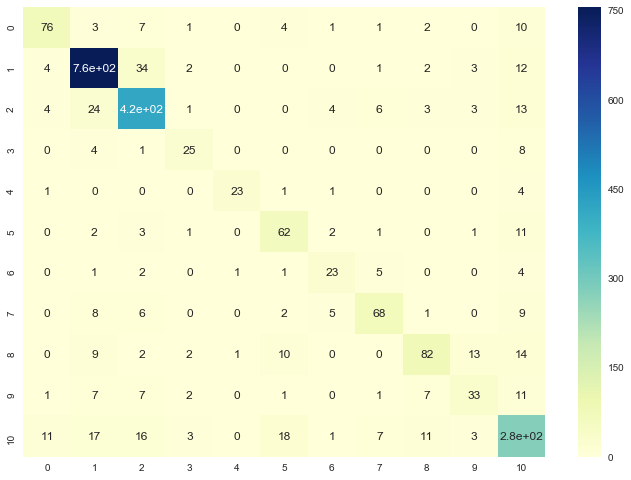

In [234]:
matrix = confusion_matrix(y_test,pred)
ax = sns.heatmap(matrix,cmap="YlGnBu",annot=True)

#### Deductions -
* Here we can see that the classifier has learned to label samples  which belongs to 'REJECTION' category (ID '10' in the heatmap) (bottom right end corner)
* Now let us evaluate using the 'DETECTION ACCURACY' or 'RATIO' by calculating how many samples are correctly labelled as REJECTED. 
* Below we can see that there are **364 samples** in REJECTION category in the test set. (third row)

In [242]:
most_common_classes(num_classes,y_test,y_test)

,Top classes,Frequency of samples
0,3,813
1,4,474
2,47,364
3,19,133
4,1,105
5,16,99
6,11,83
7,20,70
8,8,38
9,13,37


From above, the 47th (rejection) class ranks 3rd in the test set with 133 test samples

In [296]:
d = {'Actual label':y_test, 'Predicted Label': np.asarray(pred)}
df =pd.DataFrame(data=d)
df.head(20)

,Actual label,Predicted Label
0,3,3
1,10,47
2,1,47
3,4,16
4,4,13
5,3,3
6,3,4
7,3,3
8,3,3
9,3,3


** Peek into the predictions made by the classifier above** <br>
We can see that it is able to assign label -> REJECT ('47)', to some data points

In [297]:
#num_of_rejection_samples =df['Actual label'].apply(pd.value_counts)
actual_count=df.groupby('Actual label').size()
pred_count=df.groupby('Predicted Label').size()


In [298]:
total_samples_in_rejection =actual_count[47]
total_samples_rejected =pred_count[47]

In [ ]:
b=df['Predicted Label'].where(df['Predicted Label']==47)
c=df['Actual label'].where(df['Actual label']==47)
d = {'Actual label':b, 'Predicted Label': c}

df1 =pd.DataFrame(data=d)


In [302]:
count=0
for i in range(len(df1)):
    if df1['Actual label'][i] == df1['Predicted Label'][i]:
        count+=1
print('Total number of samples correctly rejected:', count) 

Total number of samples correctly rejected: 277


In [303]:
print('Detection Ratio is',count/total_samples_in_rejection)

Detection Ratio is 0.760989010989011


In [325]:
model4_f1=precision_recall_fscore_support(y_test, pred, average='micro')  #micro -> considering the imbalance in the dataset

In [327]:
model4_f1_rejection=precision_recall_fscore_support(y_test, pred, average='micro',labels=[47])  #micro -> considering the imbalance in the dataset

In [367]:
df_f2 =pd.DataFrame(data={'Precision':[model4_f1[0]],'Recall':[model4_f1[1]],'F1-score':[model4_f1[2]]},index=['Open set classifier'])
print('F1 score for all classes:')
df_f2

F1 score for all classes:


,Precision,Recall,F1-score
Open set classifier,0.819234,0.819234,0.819234


In [368]:
print('F1 score for only REJECTION CLASS labels:')
df_f2_rejection =pd.DataFrame(data={'Precision':[model4_f1_rejection[0]],'Recall':[model4_f1_rejection[1]],'F1-score':[model4_f1_rejection[2]]},index=['Open set classifier'])
df_f2_rejection

F1 score for only REJECTION CLASS labels:


,Precision,Recall,F1-score
Open set classifier,0.742627,0.760989,0.751696


## 3.3 Conclusions :
* The **Recall** for all classes if 0.81, meaning the model was able to identify 81 percent of the labels correctly out of the all cases
* For the **REJECTION** class, the Recall percentage and accuracy is around 75 percent which can be fined tuned in order to improve *open set classification*. 
* A first intuition would be to use *custom activation* function with the last layer and train some thresholding parameters to be able to reject unknown samples.
<br>
<br>
